# How to Interpolate?

In [1]:
#dataframes
import pandas as pd
import h5py
# import rosbag_pandas

#math
import numpy as np
import math
pd.TimeSeries = pd.Series 

#interpolation scipy
import scipy
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

import rosbag_pandas
#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import figurefirst
from figurefirst import FigureLayout,mpl_functions


### Using Rosbag Pandas to import Bag

In [2]:
def clean_df(df):
    df.columns=df.columns.str.replace(r"/", "_")
    df = df[df.columns.drop(list(df.filter(regex='covariance')))]
    df = df[df.columns.drop(list(df.filter(regex='frame_id')))]
    df = df[df.columns.drop(list(df.filter(regex='twist_twist_angular')))]
    df = df[df.columns.drop(list(df.filter(regex='seq')))]
    return df
def rosbag_to_pandas(filename, topics):  
    d = {name: pd.DataFrame() for name in topics}
    data = []
    for name,df in d.items():
        df = rosbag_pandas.bag_to_dataframe(filename, include=[name])
        df = clean_df(df)
        data.append(df)
    data=pd.concat(data)
    return data

In [6]:
run = 4
for i in range(0,6):
    set_number = i
    filename = '/home/ecc/data/BagsOctober/Run0'+str(run)+'/OctoberDesert1020_'+str(set_number)+'.bag'
    topics = ('/trisonica','/analog_output','/ublox_gps/fix', '/ublox_gps/fix_velocity','/imu/data')
    df= rosbag_to_pandas(filename, topics)
    df = df.reset_index()
    df = df.rename(columns={"index": "master_time"})
    df.to_hdf('/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+
              'Set0'+str(set_number)+'.h5', key='df', mode='w')
# df.keys()

### Load Data

In [3]:
# import rosbag_pandas
filename = '/Users/an/Documents/Myfiles/DataAnalysis/data/Sprints/Main/OctoberDesert1020_5.bag'
df= rosbag_pandas.bag_to_dataframe(filename, exclude=['imu/mag', '/rosout','/rosout_agg','/ublox_gps/rxmrtcm'],
                                   include=['/analog_output', '/trisonica', '/ublox_gps/fix','/ublox_gps/fix_velocity',])
df.columns=df.columns.str.replace(r"/", "_")
sync_time = df.index-df.index[0]
df.insert(0,'sync_time',sync_time)

In [4]:
df['master_time']=df.index
df=df.reset_index()
df = df.rename(columns={"index": "master_time"})

In [9]:
# data = []
# run = 4
# for i in range(1,6):
#     set_number = i 
# #     f_name = '/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+'Set0'+str(set_number)+'.h5'  
# #     f_name= '~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/ForestDataJuly_S'+str(set_number)+'.h5'
#     f_name='~/Documents/Myfiles/DataAnalysis/data/Trajectory.h5'
#     df = pd.read_hdf(f_name)
#     data.append(df)
# df=pd.concat(data)    

In [50]:
# def get_time_column(dataframe):
#     time= dataframe.master_time-dataframe.master_time[0]
#     dataframe.insert(1,'time',time) 

In [2]:
df1=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Main/Run04.h5')
df2=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Main/Run05.h5')
data = [df1,df2]
df = pd.concat(data)

In [5]:
df=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Forest/ForestDataJuly_S1.h5')

In [5]:
df1=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Main/Run03Set05.h5')

In [6]:
time= df1.master_time-df1.master_time[0]
df1.insert(1,'sync_time',time) 

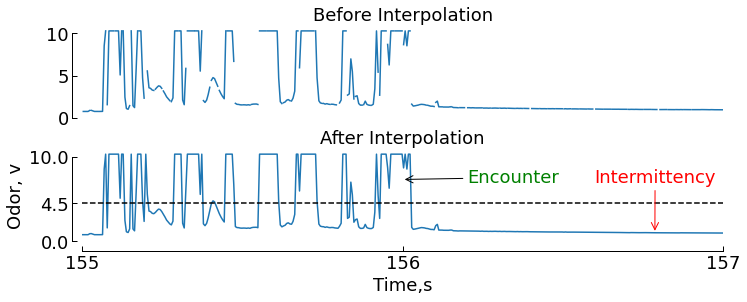

In [8]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(10,4))
ax1.plot(df.sync_time,df._analog_output_data, label='Before Interpolation')
ax1.set_xlim(155,157)

ax2.plot(df1.sync_time,df1._analog_output_data,label='After Interpolation')
ax2.set_xlim(155,157)

ax2.set_xlabel('Time,s')
ax2.set_ylabel('Odor, v')
mpl_functions.adjust_spines(ax1,['left'],spine_locations={},
                            smart_bounds=True, yticks=[0,5,10],linewidth=1)
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={},
                            smart_bounds=True, xticks=[155,156,157],yticks=[0,4.5,10],linewidth=1)

ax2.annotate('Intermittency', xy=(156.787, 1),  xycoords='data',
            xytext=(.799, .6), textcoords='axes fraction',color='red',
            arrowprops=dict(arrowstyle="->", color='red'),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax2.annotate('Encounter', xy=(156, 7.3),  xycoords='data',
            xytext=(.6, .6), textcoords='axes fraction',color='green',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax2.axhline(4.5,linestyle='--', color='black')
ax1.set_title('Before Interpolation')
ax2.set_title('After Interpolation')

# ax1.legend(loc='upper right',fancybox=False, shadow=False)
# ax2.legend(loc='upper right',fancybox=False, shadow=False)
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)


f.savefig('../../Figure/Interpolation.jpeg', dpi=300, bbox_inches = "tight")

## Interpolation

### Getting the GPS and WindSensor Time

In [6]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)
df["gps_vel_time"] = df._ublox_gps_fix_velocity_header_stamp_secs+(df._ublox_gps_fix_velocity_header_stamp_nsecs*1e-9)
df["imu_time"] = df._imu_data_header_stamp_secs +(df._imu_data_header_stamp_nsecs*1e-9)

### Separating ODOR, WIND, GPS in dataframes

In [7]:
df_odor = pd.DataFrame({'odor_time': df.master_time,
                        'odor': df._analog_output_data,})
df_wind = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,
                        'trisonica_V': df._trisonica_northsouth,'trisonica_pressure': df._trisonica_pressure,
                       'trisonica_temperature': df._trisonica_temperature})
df_gps = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,
                       'lon': df._ublox_gps_fix_longitude})
df_gps_vel = pd.DataFrame({'gps_vel_time':df.gps_vel_time,
                        'gps_linear_x':df._ublox_gps_fix_velocity_twist_twist_linear_x,
                      'gps_linear_y':df._ublox_gps_fix_velocity_twist_twist_linear_y,
                      'gps_linear_z':df._ublox_gps_fix_velocity_twist_twist_linear_z})
df_imu = pd.DataFrame({'imu_time': df.imu_time,'imu_angular_x': df._imu_data_angular_velocity_x,
                     'imu_angular_y': df._imu_data_angular_velocity_y, 
                     'imu_angular_z':df._imu_data_angular_velocity_z,
                      'imu_linear_acc_x':df._imu_data_linear_acceleration_x,
                      'imu_linear_acc_y':df._imu_data_linear_acceleration_y,
                      'imu_linear_acc_z':df._imu_data_linear_acceleration_z})

#### Creating time column for odor by dropping NaNs

In [8]:
df_odor = df_odor[df_odor.odor.notna()]

### Combined time from three sensors and arrange based on time

In [9]:
dfn = pd.concat([df_odor, df_wind, df_gps, df_gps_vel, df_imu], sort=True)
combined_time = np.hstack([df_odor.odor_time, df.trisonica_time ,df.gps_time, df.gps_vel_time, df.imu_time])
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

### Find Master Time 

In [10]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)
dt_gps_vel = np.median(np.diff(dfn.gps_vel_time.dropna().values))
print('dt Gps Vel: ', dt_gps_vel)
dt_imu = np.median(np.diff(dfn.imu_time.dropna().values))
print('dt Imu: ', dt_imu)
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_vel_time.min(),
                     dfn.gps_time.min(), dfn.imu_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max(),
                    dfn.gps_vel_time.max(),dfn.imu_time.max()])
# print(first_time,last_time)
master_time = np.arange(first_time, last_time, dt_odor)

dt Odor:  0.004995584487915039
dt Wind:  0.025004148483276367
dt Gps:  0.19999980926513672
dt Gps Vel:  0.19999980926513672
dt Imu:  0.003999948501586914


### Create Interpolation function

In [11]:
# create interpolation function and inteprolate sensor 1
df_odor_1= dfn[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.odor)
interp_odor = func_interp_sensor_1(master_time)

df_wind_1= dfn[['wind_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.trisonica_U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= dfn[['wind_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.trisonica_V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= dfn[['wind_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.trisonica_pressure)
interp_wind_p = func_interp_sensor_1(master_time)

df_wind_4= dfn[['wind_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.trisonica_temperature)
interp_wind_t = func_interp_sensor_1(master_time)


df_gps_lat= dfn[['gps_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor_1(master_time)

df_gps_lon= dfn[['gps_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor_1(master_time)

df_gps_x= dfn[['gps_vel_time', 'gps_linear_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_x.gps_vel_time, df_gps_x.gps_linear_x)
interp_gps_x = func_interp_sensor_1(master_time)

df_gps_y= dfn[['gps_vel_time', 'gps_linear_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_y.gps_vel_time, df_gps_y.gps_linear_y)
interp_gps_y = func_interp_sensor_1(master_time)

df_gps_z= dfn[['gps_vel_time', 'gps_linear_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_z.gps_vel_time, df_gps_z.gps_linear_z)
interp_gps_z = func_interp_sensor_1(master_time)


df_imu_x= dfn[['imu_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.imu_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= dfn[['imu_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.imu_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= dfn[['imu_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.imu_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= dfn[['imu_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.imu_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= dfn[['imu_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.imu_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= dfn[['imu_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.imu_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)





### New Interpolated Dataframe

In [12]:
odor = pd.DataFrame({'master_time': master_time,
                        'odor': interp_odor,
                        'trisonica_U': interp_wind_U,
                        'trisonica_V': interp_wind_V,
                        'lat': interp_gps_lat,
                        'lon': interp_gps_lon,
                        'gps_linear_x':interp_gps_x,
                        'gps_linear_y':interp_gps_y,
                        'gps_linear_z':interp_gps_z,
                        'trisonica_pressure':interp_wind_p,
                        'trisonica_temperature':interp_wind_t,
                        'imu_angular_x': interp_imu_x,
                        'imu_angular_y': interp_imu_y,
                        'imu_angular_z': interp_imu_z,
                        'imu_linear_acc_x':interp_imu_linear_acc_x,
                        'imu_linear_acc_y':interp_imu_linear_acc_y,
                        'imu_linear_acc_z':interp_imu_linear_acc_z})

# odor.to_hdf('/home/ecc/data/DesertDataOct/Run01/Run01_Interpolated.h5',key='df', mode='w')
# odor.to_hdf('~/Documents/Myfiles/DataAnalysis/data/TrajectoryInt.h5',key='df', mode='w')


In [13]:
odor.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Forest/ForestDataJuly_S1.h5',key='odor', mode='w')

## Interpolating Wind and Odor

In [17]:
#ubuntu
# fname='~/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
# fname='~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/WindStationA.hdf'
#mac 
fname = '~/Documents/Myfiles/DataAnalysis/data/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
# wind_df.keys()
wind_df.reset_index(inplace=True, drop=True) 
wind =pd.DataFrame()
wind = wind_df.loc[(wind_df.time_epoch >= odor.master_time.iloc[0]) & 
                   (wind_df.time_epoch <= odor.master_time.iloc[-1])]
# df2.to_hdf('/home/ecc/data/DesertDataOct/Run01/Wind01.h5', key='df2', mode='w')

### Converting lat lon information to meters

In [24]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

#source location to meters
source = (40.79376709443614, -119.15757512132207) #desert
# source =(39.252441,-119.878037)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)
# u =  utm.from_latlon(39.252441, -119.878037)
xfromsrc= geodf.x-u[0]
geodf.insert(9,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(10,'ysrc', yfromsrc)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Interpolate

In [25]:
df_odor_loc=pd.DataFrame({'odor_time': geodf.master_time,'xsrc': geodf.xsrc, 'ysrc':geodf.ysrc, 
                          'odor':geodf.odor, 'lat':geodf.lat, 'lon':geodf.lon,
                          'trisonica_U':geodf.trisonica_U, 'trisonica_V':geodf.trisonica_V,
                          'trisonica_temperature':geodf.trisonica_temperature,
                          'trisonica_pressure':geodf.trisonica_pressure,
                          'gps_linear_x':geodf.gps_linear_x,
                          'gps_linear_y':geodf.gps_linear_y,
                          'gps_linear_z':geodf.gps_linear_z,
                          'imu_angular_x': geodf.imu_angular_x,
                          'imu_angular_y': geodf.imu_angular_y,
                          'imu_angular_z': geodf.imu_angular_z,
                          'imu_linear_acc_x':geodf.imu_linear_acc_z,
                          'imu_linear_acc_y':geodf.imu_linear_acc_z,
                          'imu_linear_acc_z':geodf.imu_linear_acc_z
                         })
df_wind_loc=pd.DataFrame({'wind_time': wind.time_epoch,'U': wind.U,'V': wind.V, 'D':wind.D , 'S2':wind.S2})


df_new = pd.concat([df_odor_loc,df_wind_loc], sort=True)
combined_time = np.hstack([df_odor_loc.odor_time, df_wind_loc.wind_time])

df_new['time'] = combined_time
df_new=df_new.sort_values(by=['time'])

dt_odor = np.median(np.diff(df_new.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(df_new.wind_time.dropna().values))
print('dt Wind: ', dt_wind)

first_time = np.max([df_new.odor_time.min(), df_new.wind_time.min()])
last_time = np.min([df_new.odor_time.max(), df_new.wind_time.max()])
############## SELECT THE RESOLUTION HERE ####################
master_time = np.arange(first_time, last_time, dt_odor)

# create interpolation function and inteprolate sensor 1
df_odor_1= df_new[['odor_time', 'xsrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.xsrc)
interp_odor_x = func_interp_sensor_1(master_time)

df_odor_2= df_new[['odor_time', 'ysrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_2.odor_time, df_odor_2.ysrc)
interp_odor_y = func_interp_sensor_1(master_time)

df_odor_la= df_new[['odor_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_la.odor_time, df_odor_la.lat)
interp_odor_la = func_interp_sensor_1(master_time)

df_odor_lo= df_new[['odor_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_lo.odor_time, df_odor_lo.lon)
interp_odor_lo = func_interp_sensor_1(master_time)

df_odor_3= df_new[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_3.odor_time, df_odor_3.odor)
interp_odor = func_interp_sensor_1(master_time)

df_gps_x= df_new[['odor_time', 'gps_linear_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_x.odor_time, df_gps_x.gps_linear_x)
interp_gps_x = func_interp_sensor_1(master_time)

df_gps_y= df_new[['odor_time', 'gps_linear_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_y.odor_time, df_gps_y.gps_linear_y)
interp_gps_y = func_interp_sensor_1(master_time)

df_gps_z= df_new[['odor_time', 'gps_linear_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_z.odor_time, df_gps_z.gps_linear_z)
interp_gps_z = func_interp_sensor_1(master_time)



df_wind_1x= df_new[['odor_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1x.odor_time, df_wind_1x.trisonica_U)
interp_wind_Ux = func_interp_sensor_1(master_time)

df_wind_2x= df_new[['odor_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2x.odor_time, df_wind_2x.trisonica_V)
interp_wind_Vx = func_interp_sensor_1(master_time)

df_wind_3x= df_new[['odor_time', 'trisonica_pressure']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3x.odor_time, df_wind_3x.trisonica_pressure)
interp_wind_px = func_interp_sensor_1(master_time)

df_wind_4x= df_new[['odor_time', 'trisonica_temperature']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4x.odor_time, df_wind_4x.trisonica_temperature)
interp_wind_tx = func_interp_sensor_1(master_time)

df_imu_x= df_new[['odor_time', 'imu_angular_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_x.odor_time, df_imu_x.imu_angular_x)
interp_imu_x = func_interp_sensor_1(master_time)

df_imu_y= df_new[['odor_time', 'imu_angular_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_y.odor_time, df_imu_y.imu_angular_y)
interp_imu_y = func_interp_sensor_1(master_time)


df_imu_z= df_new[['odor_time', 'imu_angular_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_z.odor_time, df_imu_z.imu_angular_z)
interp_imu_z = func_interp_sensor_1(master_time)


df_imu_linear_x= df_new[['odor_time', 'imu_linear_acc_x']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_x.odor_time, df_imu_linear_x.imu_linear_acc_x)
interp_imu_linear_acc_x = func_interp_sensor_1(master_time)

df_imu_linear_y= df_new[['odor_time', 'imu_linear_acc_y']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_y.odor_time, df_imu_linear_y.imu_linear_acc_y)
interp_imu_linear_acc_y = func_interp_sensor_1(master_time)


df_imu_linear_z= df_new[['odor_time', 'imu_linear_acc_z']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_imu_linear_z.odor_time, df_imu_linear_z.imu_linear_acc_z)
interp_imu_linear_acc_z = func_interp_sensor_1(master_time)




df_wind_1= df_new[['wind_time', 'U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= df_new[['wind_time', 'V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.V)
interp_wind_V = func_interp_sensor_1(master_time)

df_wind_3= df_new[['wind_time', 'D']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_3.wind_time, df_wind_3.D)
interp_wind_D = func_interp_sensor_1(master_time)

df_wind_4= df_new[['wind_time', 'S2']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_4.wind_time, df_wind_4.S2)
interp_wind_S2 = func_interp_sensor_1(master_time)



windn = pd.DataFrame({'master_time': master_time,
                            'xsrc': interp_odor_x,
                            'ysrc': interp_odor_y,
                            'lat': interp_odor_la,
                            'lon': interp_odor_lo,  
                            'odor': interp_odor,
                            'trisonica_u': interp_wind_Ux,
                            'trisonica_v': interp_wind_Vx,
                            'trisonica_pressure':interp_wind_px,
                            'trisonica_temperature':interp_wind_tx,
                            'gps_linear_x': interp_gps_x,
                            'gps_linear_y': interp_gps_y,
                            'gps_linear_z': interp_gps_z,
                            'imu_angular_x': interp_imu_x,
                            'imu_angular_y': interp_imu_y,
                            'imu_angular_z': interp_imu_z,
                            'imu_linear_acc_x':interp_imu_linear_acc_x,
                            'imu_linear_acc_y':interp_imu_linear_acc_y,
                            'imu_linear_acc_z':interp_imu_linear_acc_z,
                      
                            'U': interp_wind_U,
                            'V': interp_wind_V,
                            'D':interp_wind_D,
                            'S2':interp_wind_S2})

# windn.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/Windy/Run04Run05HD.h5',key='windn',mode='w')
# windn.to_hdf('/home/ecc/data/DesertDataOct/Run0'+str(run)+'/Run0'+str(run)+'.h5',key='windn', mode='w')
# windn.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/ForestInterpolated.h5', key='windn', mode='w')

dt Odor:  0.004997968673706055
dt Wind:  0.10000276565551758


In [36]:
get_time_column(dfbefore)

In [36]:
time= odor.master_time-odor.master_time[0]
odor.insert(1,'time',time) 

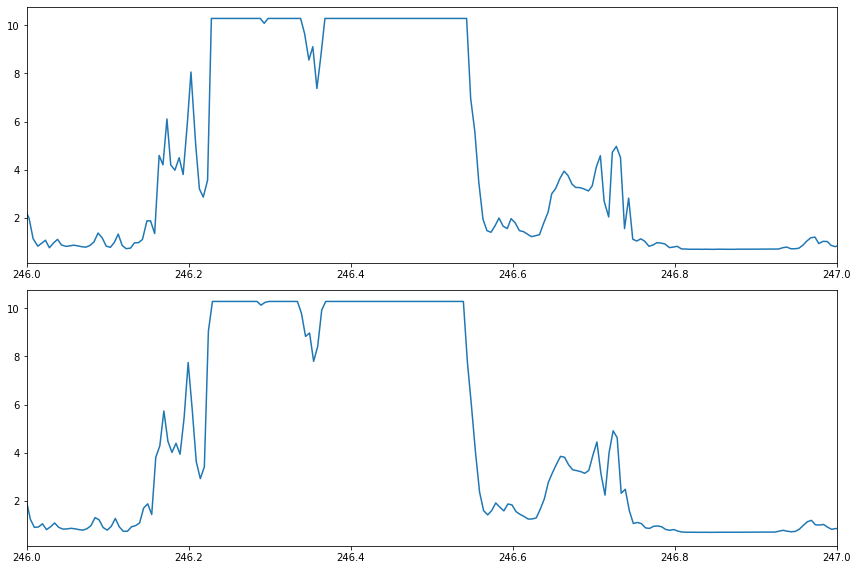

In [48]:
f,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(df.time,df._analog_output_data)
ax[1].plot(odor.time,odor.odor)

x=246
y=247
ax[0].set_xlim(x,y)
ax[1].set_xlim(x,y)
# ax[1].set_xlim(75,80)
f.tight_layout(pad=1)